## 单只绩效分析

In [8]:
from single_nav_analysis import NavAnalysisConfig, SingleNavAnalysis
from pathlib import Path
import numpy as np


nav_analysis_config = NavAnalysisConfig(
    bench_data_path=Path(r"C:\Euclid_Jie\barra\src\nav_analysis\index_data.csv"),
    # nav_data_path=Path(r"C:\Users\Ouwei\Desktop\管理人单页\SLD035-同温层量化阿尔法1号.xlsx"),
    nav_data_path=Path(
        r"C:\Users\Ouwei\Desktop\nav_data\净值库1101\按策略分\500增强\宽德500S-SVN545.xlsx"
    ),
    # begin_date=np.datetime64("2023-12-29"),
    open_html=False,
    benchmark="SHSE.000905",
)
demo = SingleNavAnalysis(nav_analysis_config)
demo.analysis()
demo.export_html(save=True)
demo

开始读取宽德500S-SVN545净值数据
原始数据时间区间为：2022-11-04 ~ 2024-11-01
本次统计时间区间为：2022-11-04 ~ 2024-11-01
html路径为：C:\Users\Ouwei\Desktop\nav_data\净值库1101\按策略分\500增强\20221104_20241101_宽德500S-SVN545_nav_analysis.html


宽德500S-SVN545净值分析[W]：2022-11-04 ~ 2024-11-01

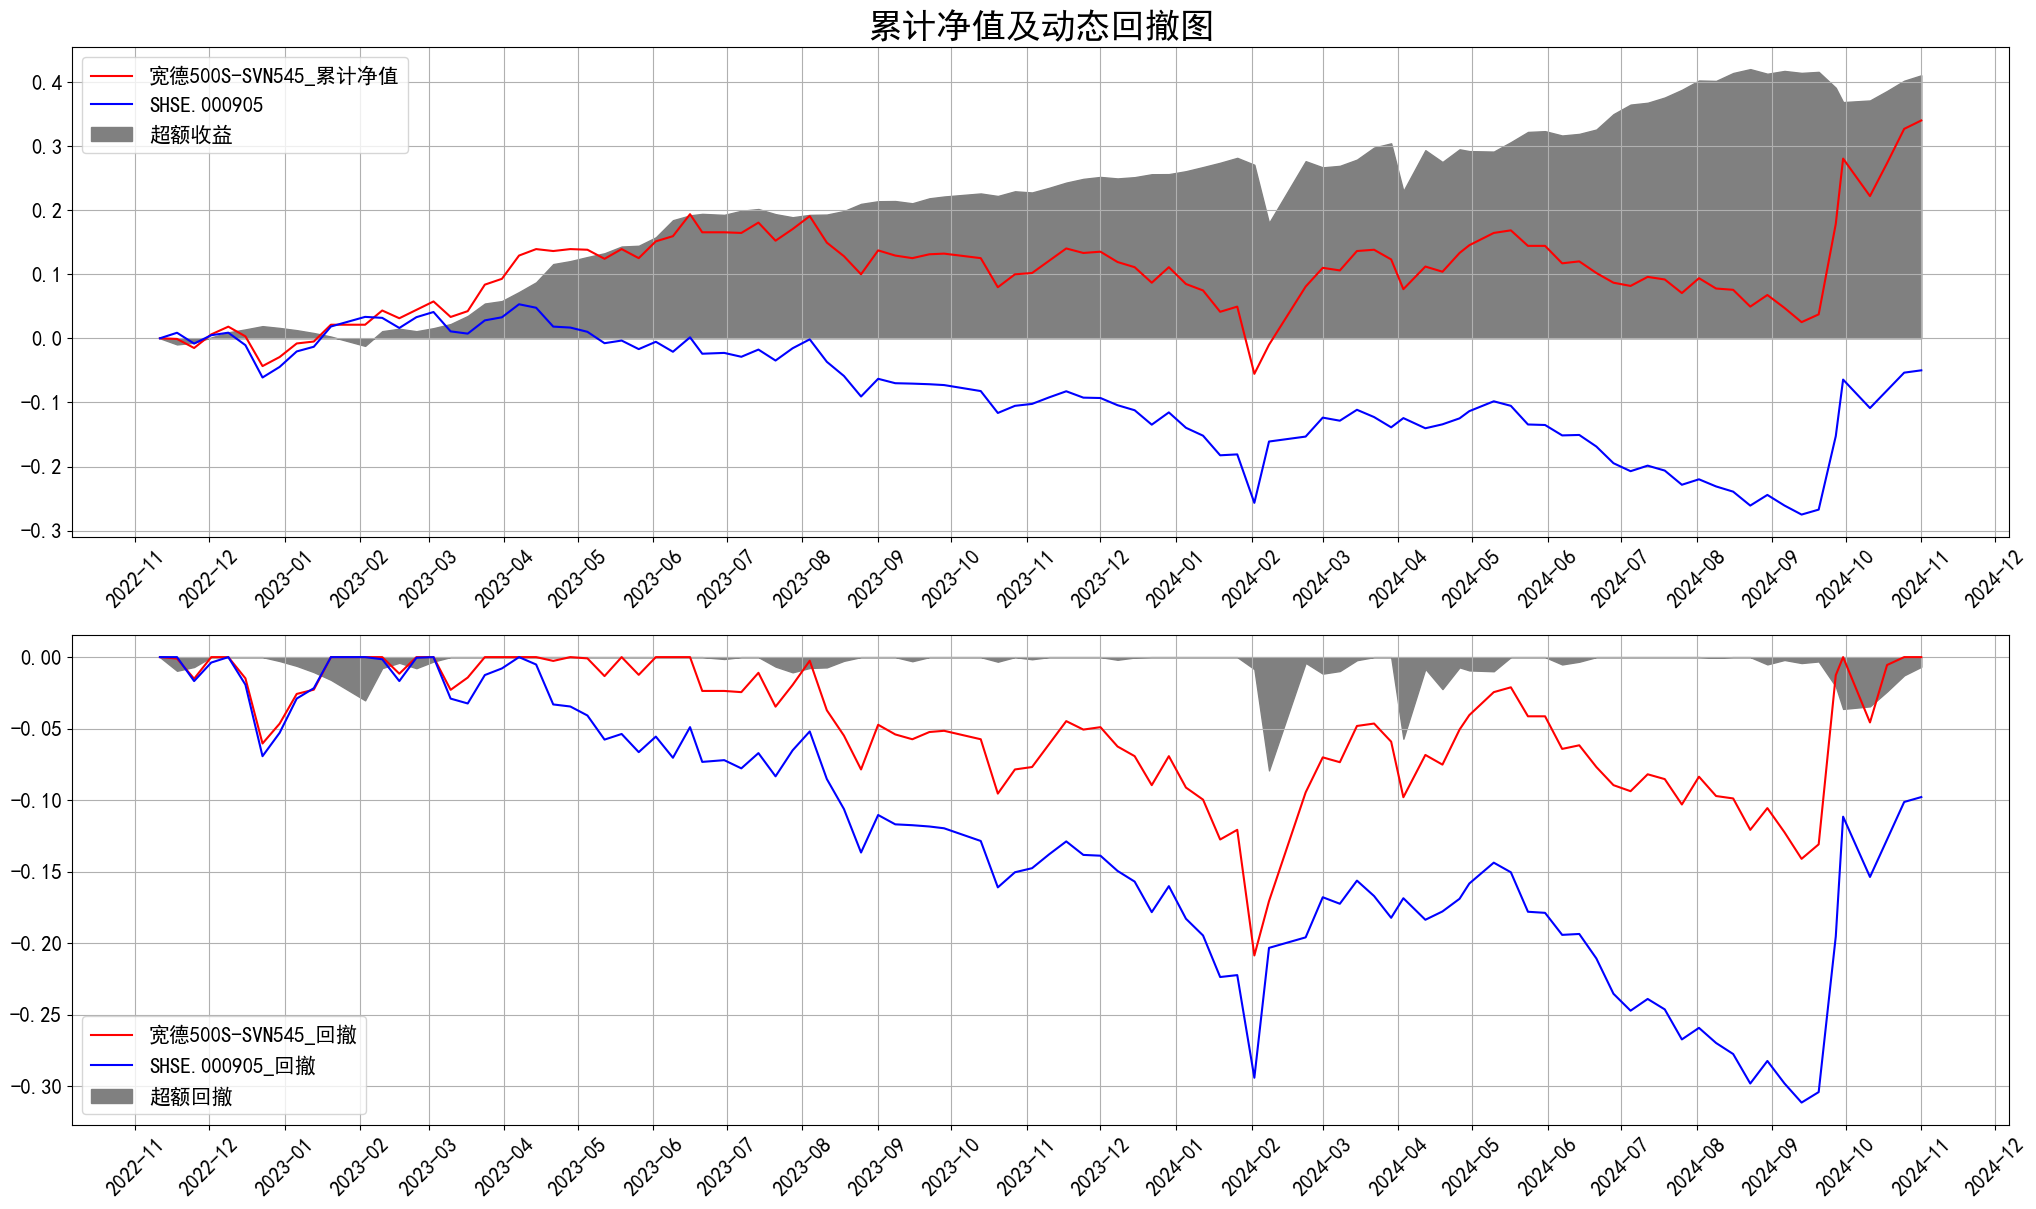

In [9]:
demo.plot("upper")

In [18]:
demo.monthly_rtn_df.to_csv(
    r"C:\Users\Ouwei\Desktop\monthly_rtn.csv", index=True, encoding="utf_8_sig"
)

## 自动生成index.html

In [8]:
from pathlib import Path


def generate_index_html(folder_path: Path):
    # 获取目录及其子目录中的所有 HTML 文件
    html_files = folder_path.rglob("*.html")
    print(html_files)

    # 创建一个新的 index.html 文件
    with open(folder_path.joinpath("index.html"), "w", encoding="utf-8") as f:
        f.write(
            """<html>
<head>
<meta charset="UTF-8">
<title>Value over Time</title>
</head>
<body>"""
        )

        # 创建一个集合来存储已经处理过的文件夹，避免重复创建链接
        processed_folders = set()
        # 为每个 HTML 文件创建一个链接
        for html_file in html_files:
            if html_file.name == "index.html":
                continue
            relative_path = html_file.relative_to(folder_path)
            # 如果文件夹还没有被处理过，为文件夹创建一个链接
            if html_file.parent not in processed_folders:
                f.write(f"<h2><a>{html_file.parent.name}</a></h2>\n")
                processed_folders.add(html_file.parent)

            # 创建HTML文件的链接
            f.write(
                f'<a href="{relative_path}">{relative_path.name.replace("_nav_analysis","")}</a><br/>\n'
            )

        f.write("</body>\n</html>")


# 使用函数
generate_index_html(Path(r"C:\Euclid_Jie\barra\submodule\nav_analysis\docs"))

<generator object Path.rglob at 0x0000016DAF3FFCD0>


## 双庆backword analysis 需求

In [19]:
from utils import backword_analysis
import pandas as pd

nav_data = pd.read_excel(r"C:\Users\Ouwei\Desktop\nav_data\0829双庆\nav_data.xlsx")
# 截取时间
nav_data = nav_data[nav_data["日期"] >= pd.to_datetime("2019-12-30")]
nav_data.set_index("日期", inplace=True)
nav_data = nav_data.ffill(limit_area="inside")

In [57]:
out = pd.DataFrame()
for name in nav_data.columns:
    single_nav_data = nav_data[name].reset_index(drop=False)
    single_nav_data = single_nav_data[~single_nav_data[name].isna()]
    if len(single_nav_data) < 10:
        continue
    res = backword_analysis(
        single_nav_data[name].values, single_nav_data["日期"].values, freq="W"
    ).reset_index(drop=False)
    res["产品"] = name
    out = pd.concat([out, res], axis=0)
out["策略类型"] = out["产品"].apply(lambda x: x.split("_")[-1])

In [58]:
out = out[out["backword months"].isin(["12M", "24M", "36M"])]
out = out[
    ["策略类型", "产品", "backword months", "年化收益率", "年化波动率", "夏普比率"]
]

,策略类型,产品,backword months,年化收益率,年化波动率,夏普比率
3,期现套利,0_博普日添月益_期现套利,12M,8.483%,1.395%,6.080
4,期现套利,0_博普日添月益_期现套利,24M,6.714%,1.348%,4.980
5,期现套利,0_博普日添月益_期现套利,36M,5.890%,1.717%,3.431
3,1000中性,0_麦迪生利锐联中性对冲1号_1000中性,12M,12.449%,5.925%,2.101
3,500指增,0_超量子中证500增强2号_500指增,12M,-5.693%,24.438%,-0.233
...,...,...,...,...,...,...
3,可转债套利,2_悬铃稳健金选1号_可转债套利,12M,-2.845%,7.960%,-0.357
3,指增,2_弈倍虎鲸_指增,12M,-13.005%,23.790%,-0.547
4,指增,2_弈倍虎鲸_指增,24M,-10.528%,20.929%,-0.503
5,指增,2_弈倍虎鲸_指增,36M,-5.651%,19.902%,-0.284


In [65]:
year = 1
res = pd.DataFrame()
for i in ["12M", "24M", "36M"]:
    data_i = out[out["backword months"] == i]
    data_i = data_i.drop("backword months", axis=1)
    data_i = data_i.rename(
        {
            "年化收益率": f"过去{year}_年化收益率",
            "年化波动率": f"过去{year}_年化波动率",
            "夏普比率": f"过去{year}_夏普比率",
        },
        axis=1,
    )
    year += 1
    res = pd.concat([res, data_i])

In [75]:
year = 3
data_i = out[out["backword months"] == "36M"]
data_i = data_i.drop("backword months", axis=1)
data_i = data_i.rename(
    {
        "年化收益率": f"过去{year}_年化收益率",
        "年化波动率": f"过去{year}_年化波动率",
        "夏普比率": f"过去{year}_夏普比率",
    },
    axis=1,
)

In [76]:
data_3 = data_i.copy()

In [78]:
res = data_1.merge(data_2, on=["策略类型", "产品"], how="left")
res = res.merge(data_3, on=["策略类型", "产品"], how="left")

In [68]:
res.sort_values(["策略类型", "产品"]).to_csv(
    r"C:\Users\Ouwei\Desktop\res_backword_analysis.csv",
    index=False,
    encoding="utf_8_sig",
)

In [ ]:
out.to_csv(
    r"C:\Users\Ouwei\Desktop\backword_analysis.csv", index=False, encoding="utf-8-sig"
)

## 多只对比

In [9]:
from compare_nav_analysis import NavAnalysisConfig, CompareNavAnalysis
from pathlib import Path
import numpy as np

nav_analysis_config = NavAnalysisConfig(
    bench_data_path=Path(r"C:\Euclid_Jie\barra\src\nav_analysis\index_data.csv"),
    nav_data_path=[
        Path(
            r"C:\Users\Ouwei\Desktop\nav_data\净值库1101\按策略分\500增强\宽德500S-SVN545.xlsx"
        ),
        Path(
            r"C:\Users\Ouwei\Desktop\nav_data\净值库1101\按策略分\500增强\赫富500G-SQF460.xlsx"
        ),
    ],
    # begin_date=np.datetime64("2023-12-31"),
    # end_date=np.datetime64("2024-06-07"),
    open_html=False,
    benchmark="SHSE.000905",
)
demo = CompareNavAnalysis(nav_analysis_config, strip_date=False)
demo.anlysis()
demo.export_html(save=True)

宽德500S-SVN545，原始数据时间区间为：2022-11-04 - 2024-11-01
赫富500G-SQF460，原始数据时间区间为：2021-09-24 - 2024-11-01
本次统计时间区间为：2022-11-04 ~ 2024-11-01
开始读取宽德500S-SVN545净值数据
原始数据时间区间为：2022-11-04 ~ 2024-11-01
本次统计时间区间为：2022-11-04 ~ 2024-11-01
开始读取赫富500G-SQF460净值数据
无法推断频率, 将自动转为周度
原始数据时间区间为：2021-09-24 ~ 2024-11-01
本次统计时间区间为：2022-11-04 ~ 2024-11-01
html路径为：C:\Users\Ouwei\Desktop\nav_data\净值库1101\按策略分\500增强\20221104_20241101_compare_nav_analysis.html


In [10]:
nav_df= demo.nav_df.copy()
rtn_df = nav_df.pct_change().dropna()
rtn_df

,宽德500S-SVN545,SHSE.000905,超额_宽德500S-SVN545,赫富500G-SQF460,超额_赫富500G-SQF460
2022-11-11,0.000000,0.000000,0.000000,0.000000,0.000000
2022-11-18,-0.001008,0.008638,-0.009564,-0.000845,-0.009402
2022-11-25,-0.014127,-0.016763,0.002680,-0.009095,0.007799
2022-12-02,0.021494,0.013166,0.008220,0.027535,0.014182
2022-12-09,0.012024,0.003938,0.008055,0.008621,0.004665
...,...,...,...,...,...
2024-09-30,0.086399,0.104111,-0.016042,0.106922,0.002546
2024-10-11,-0.045669,-0.047431,0.001849,-0.040666,0.007101
2024-10-18,0.042079,0.030929,0.010816,0.042099,0.010835
2024-10-25,0.041964,0.030083,0.011534,0.032672,0.002514


## 因子分析初步

In [3]:
from utils import load_bench_data
import pandas as pd
index_df =  load_bench_data(r"C:\Euclid_Jie\barra\src\nav_analysis\index_data.csv")
index_df["date"] = pd.to_datetime(index_df["bob"])
index_df.set_index("date", inplace=True)

In [11]:
SHSE_000300 = index_df[index_df["symbol"] == "SHSE.000300"]
SHSE_000905 = index_df[index_df["symbol"] == "SHSE.000905"]
SHSE_000852 = index_df[index_df["symbol"] == "SHSE.000852"]
SZSE_399303 = index_df[index_df["symbol"] == "SZSE.399303"]

In [12]:
SHSE_000300_rtn = SHSE_000300["close"].pct_change().reindex(rtn_df.index).values
SHSE_000905_rtn = SHSE_000905["close"].pct_change().reindex(rtn_df.index).values
SHSE_000852_rtn = SHSE_000852["close"].pct_change().reindex(rtn_df.index).values
SHSE_000300_rtn = SHSE_000300["close"].pct_change().reindex(rtn_df.index).values

In [80]:
from regression import rolling_regression
name = "宽德500S-SVN545"
betas, errors, t, F, R2 = rolling_regression(
    Y=rtn_df[name].values,
    Xs=[
        SHSE_000300_rtn,
        SHSE_000905_rtn,
        SHSE_000852_rtn,
        SHSE_000300_rtn,
    ],
    window=13,
)
betas_df = pd.DataFrame(
    betas,
    columns=["SHSE.000300", "SHSE.000905", "SHSE.000852", "SZSE.399303"],
    index=rtn_df.index[12:],
)

# betas_df = betas_df / betas_df.abs().sum(axis=1).values.reshape(-1, 1)

 WARNING  regression: Conditioon number for OLS X variables is large : 89 times over 89 periods


In [83]:
betas_df.to_csv(r"C:\Users\Ouwei\Desktop\betas.csv", index=True, encoding="utf_8_sig")

In [92]:
import plotly.express as px
import plotly.graph_objects as go

# 将数据转换为长格式
df_long = betas_df.reset_index(drop=False).melt(
    id_vars="index", var_name="name", value_name="Value"
)
# 绘制面积图
fig = px.bar(df_long, x="index", y="Value", color="name", title=f"{name} Beta")
# x密度加大
fig.update_xaxes(tickangle=-90, tickformat="%Y-%m-%d", tickvals=betas_df.index)
fig.update_layout(
    yaxis1=dict(
        title="敏感度",
        side="right",
    )
)

nav_max = (rtn_df[name].values + 1).cumprod().max()
# 增加一条折线, 使用另一个 y 轴, 设置区间为 0-1
fig.update_layout(
    yaxis2=dict(
        title="nav",
        titlefont=dict(color="black"),
        tickfont=dict(color="black"),
        overlaying="y",
        side="left",
        # range=[-nav_max + 1.9, nav_max + 0.1],
    )
)
# 虚线
fig.add_trace(
    go.Scatter(
        x=betas_df.index,
        y=(rtn_df[name].values + 1).cumprod(),
        mode="lines",
        name="nav",
        line=dict(color="black"),
        yaxis="y2",
    )
)
# 显示图表
fig.show()